In [2]:
cd ..

/home/abdalrhman/Desktop/Graduation Project/AiStore/Recommender_V1


In [3]:
import os
import sys
import pandas as pd
NOTEBOOK_DIR = os.getcwd() 
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../../"))  

# Add the project root to sys.path
sys.path.append(PROJECT_ROOT)

from srcs.utils.settings import (
    CLEANED_METADATA_PATH_CSV, CLEANED_REVIEWS_PATH_CSV, FULL_GRAPH_PATH,
    TRAIN_GRAPH_PATH, VAL_GRAPH_PATH, TEST_GRAPH_PATH, PROCESSED_REVIEWS_TABULAR_DATA,
    PROCESSED_META_TABULAR_DATA
)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

reviews_df = pd.read_csv(PROCESSED_REVIEWS_TABULAR_DATA)
meta_df = pd.read_csv(PROCESSED_META_TABULAR_DATA)

In [5]:
reviews_df.head()

,user_id,parent_asin,rating,timestamp,year,month,day,hour,minute,recency,recency_weight
0,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,B08P3VMW76,5.0,2017-01-02 03:24:55.000,2017,1,2,3,24,3042,0.000329
1,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,B00V3KLZSW,5.0,2016-06-01 14:39:40.000,2016,6,1,14,39,3257,0.000307
2,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B08XBLP2V8,5.0,2019-04-28 23:54:57.617,2019,4,28,23,54,2195,0.000455
3,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B09FF1RNDT,5.0,2019-06-12 22:28:30.311,2019,6,12,22,28,2150,0.000465
4,AGPR2UDFIJJCBA3EKFEEAJBWKROQ,B0BW4PFM58,5.0,2018-01-26 18:12:57.487,2018,1,26,18,12,2653,0.000377


In [6]:
meta_df.head()

,main_category,title,average_rating,rating_number,price,store,parent_asin,n_features,n_description_items,first_image,brand,color,date_first_available,primary_category,rating_bin
0,Computers,Digi-Tatoo Decal Skin Compatible With MacBook ...,4.5,246,19.99,Digi-Tatoo,B07SM135LS,5,0,https://m.media-amazon.com/images/I/31t4bj9t88...,Digi-Tatoo,Fresh Marble,2019-06-03,Electronics,Medium
1,Amazon Fashion,NotoCity Compatible with Vivoactive 4 band 22m...,4.5,233,9.99,Notocity,B089CNGZCW,5,0,https://m.media-amazon.com/images/I/41j56fjX6S...,Unknown,Unknown,2020-05-29,Electronics,Medium
2,Cell Phones & Accessories,Motorola Droid X Essentials Combo Pack,3.8,64,14.99,Verizon,B004E2Z88O,3,1,https://m.media-amazon.com/images/I/51-DXSMlHa...,Unknown,Unknown,2010-11-26,Electronics,Medium
3,Cell Phones & Accessories,"QGHXO Band for Garmin Vivofit 4, Soft Silicone...",4.4,707,14.89,Qghxo,B07BJ7ZZL7,5,10,https://m.media-amazon.com/images/I/51UefzXMzv...,Unknown,5Pcs Bands-Girl,2018-03-17,Electronics,Medium
4,Cell Phones & Accessories,May Chen Compatible with MacBook Pro 16 inch C...,4.5,649,26.99,May Chen,B0822SL7JX,5,1,https://m.media-amazon.com/images/I/51mR3hFRLs...,May Chen,Abstract Leaves,2023-02-06,Electronics,Medium


In [7]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# 1. Load both datasets
# reviews_df = pd.read_csv("tabular_reviews_df.csv")
# meta_df    = pd.read_csv("tabular_meta_df.csv")

# 2. Merge on 'parent_asin'
df = pd.merge(reviews_df, meta_df, on="parent_asin", how="inner")


df.head()

,user_id,parent_asin,rating,timestamp,year,month,day,hour,minute,recency,...,price,store,n_features,n_description_items,first_image,brand,color,date_first_available,primary_category,rating_bin
0,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,B08P3VMW76,5.0,2017-01-02 03:24:55.000,2017,1,2,3,24,3042,...,19.99,Usa Gear,5,0,https://m.media-amazon.com/images/I/41CrjC7Ou1...,Usa Gear,Deluxe Gray,2012-10-02,Electronics,Medium
1,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,B00V3KLZSW,5.0,2016-06-01 14:39:40.000,2016,6,1,14,39,3257,...,8.99,Igottech,5,11,https://m.media-amazon.com/images/I/41Hj8hQZbH...,Igottech,"Multicolor, Multicolored",2015-03-23,Electronics,Medium
2,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B08XBLP2V8,5.0,2019-04-28 23:54:57.617,2019,4,28,23,54,2195,...,26.99,Wavlink,5,0,https://m.media-amazon.com/images/I/41sm7mepEC...,Wavlink,Upgraded-Hdd Dock,2022-06-09,Electronics,Medium
3,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B09FF1RNDT,5.0,2019-06-12 22:28:30.311,2019,6,12,22,28,2150,...,44.99,Addlink,4,0,https://m.media-amazon.com/images/I/412XBxKw+g...,Addlink,S20,2019-02-04,Electronics,High
4,AGPR2UDFIJJCBA3EKFEEAJBWKROQ,B0BW4PFM58,5.0,2018-01-26 18:12:57.487,2018,1,26,18,12,2653,...,24.99,Cambridge Soundworks,5,0,https://m.media-amazon.com/images/I/41feNmZQBh...,Cambridge Soundworks,Unknown,2015-07-01,Electronics,Medium


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import joblib
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Convert ratings into binary relevance (relevant or not relevant)
def binary_relevance(rating, threshold=4):
    return 1 if rating >= threshold else 0

df['binary_relevance'] = df['rating'].apply(binary_relevance)

# Step 2: Drop irrelevant or problematic columns
drop_cols = [
    "first_image",          # URL, not needed for modeling
    "date_first_available", # Date, not needed for now
    "user_id",              # User ID, not needed for modeling
    "parent_asin",          # Parent ASIN, not needed for modeling
    "timestamp",            # Timestamp, not needed for modeling
    "title"                 # Title, not directly useful for the model
]
df = df.drop(columns=drop_cols, errors="ignore")

# Step 3: Handle missing values
df = df.fillna("Unknown")


df.head()

,rating,year,month,day,hour,minute,recency,recency_weight,main_category,average_rating,rating_number,price,store,n_features,n_description_items,brand,color,primary_category,rating_bin,binary_relevance
0,5.0,2017,1,2,3,24,3042,0.000329,Camera & Photo,4.5,8841,19.99,Usa Gear,5,0,Usa Gear,Deluxe Gray,Electronics,Medium,1
1,5.0,2016,6,1,14,39,3257,0.000307,All Electronics,4.1,1425,8.99,Igottech,5,11,Igottech,"Multicolor, Multicolored",Electronics,Medium,1
2,5.0,2019,4,28,23,54,2195,0.000455,All Electronics,4.4,770,26.99,Wavlink,5,0,Wavlink,Upgraded-Hdd Dock,Electronics,Medium,1
3,5.0,2019,6,12,22,28,2150,0.000465,Computers,4.6,387,44.99,Addlink,4,0,Addlink,S20,Electronics,High,1
4,5.0,2018,1,26,18,12,2653,0.000377,All Electronics,4.5,190291,24.99,Cambridge Soundworks,5,0,Cambridge Soundworks,Unknown,Electronics,Medium,1


In [9]:
def frequency_encoding(df, column):
    # Frequency of each category as a fraction of total count
    freq_map = df[column].value_counts() / len(df)
    df[column] = df[column].map(freq_map)
    return df

# Apply frequency encoding to categorical columns
categorical_columns = ['store', 'brand', 'color', 'primary_category']

for col in categorical_columns:
    df = frequency_encoding(df, col)

# Step 5: Feature scaling for numerical features like price
scaler = MinMaxScaler()

# We are using 'price' column here, but you may add more numerical columns for scaling if needed
df['price_scaled'] = scaler.fit_transform(df[['price']])


# Drop columns 'store', 'brand', and 'color'
df = df.drop(columns=['main_category', 'rating_bin'])


# View the DataFrame after transformations
df.head()

,rating,year,month,day,hour,minute,recency,recency_weight,average_rating,rating_number,price,store,n_features,n_description_items,brand,color,primary_category,binary_relevance,price_scaled
0,5.0,2017,1,2,3,24,3042,0.000329,4.5,8841,19.99,0.001578,5,0,0.001530,0.000638,0.990619,1,0.021135
1,5.0,2016,6,1,14,39,3257,0.000307,4.1,1425,8.99,0.000394,5,11,0.000394,0.000394,0.990619,1,0.008899
2,5.0,2019,4,28,23,54,2195,0.000455,4.4,770,26.99,0.000481,5,0,0.000468,0.000085,0.990619,1,0.028921
3,5.0,2019,6,12,22,28,2150,0.000465,4.6,387,44.99,0.000368,4,0,0.000368,0.000070,0.990619,1,0.048943
4,5.0,2018,1,26,18,12,2653,0.000377,4.5,190291,24.99,0.012262,5,0,0.012262,0.265903,0.990619,1,0.026696


In [10]:
# Step 6: Convert categorical columns to 'category' dtype
for col in categorical_columns:
    df[col] = df[col].astype("category")

# Step 7: Split the Data into Training and Testing Sets
X = df.drop(columns=['binary_relevance', 'rating'])  # Features
y = df['binary_relevance']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training LightGBM Model

Epoch 1: Precision = 0.8692, Recall = 0.8692, AUC = 0.8593, Loss = 0.6432
Epoch 2: Precision = 0.8692, Recall = 0.8692, AUC = 0.8593, Loss = 0.6016
Epoch 3: Precision = 0.8692, Recall = 0.8692, AUC = 0.8803, Loss = 0.5676
Epoch 4: Precision = 0.8692, Recall = 0.8692, AUC = 0.8875, Loss = 0.5378
Epoch 5: Precision = 0.8692, Recall = 0.8692, AUC = 0.8875, Loss = 0.5139
Epoch 6: Precision = 0.8692, Recall = 0.8692, AUC = 0.8875, Loss = 0.4925
Epoch 7: Precision = 0.8692, Recall = 0.8692, AUC = 0.8875, Loss = 0.4755
Epoch 8: Precision = 0.8692, Recall = 0.8692, AUC = 0.8875, Loss = 0.4600
Epoch 9: Precision = 0.8692, Recall = 0.8692, AUC = 0.8885, Loss = 0.4488
Epoch 10: Precision = 0.8692, Recall = 0.8692, AUC = 0.8855, Loss = 0.4384
Epoch 11: Precision = 0.8692, Recall = 0.8692, AUC = 0.8855, Loss = 0.4303
Epoch 12: Precision = 0.8692, Recall = 0.8692, AUC = 0.8837, Loss = 0.4238
Epoch 13: Precision = 0.8692, Recall = 0.8692, AUC = 0.9024, Loss = 0.4166
Epoch 14: Precision = 0.8692, Reca

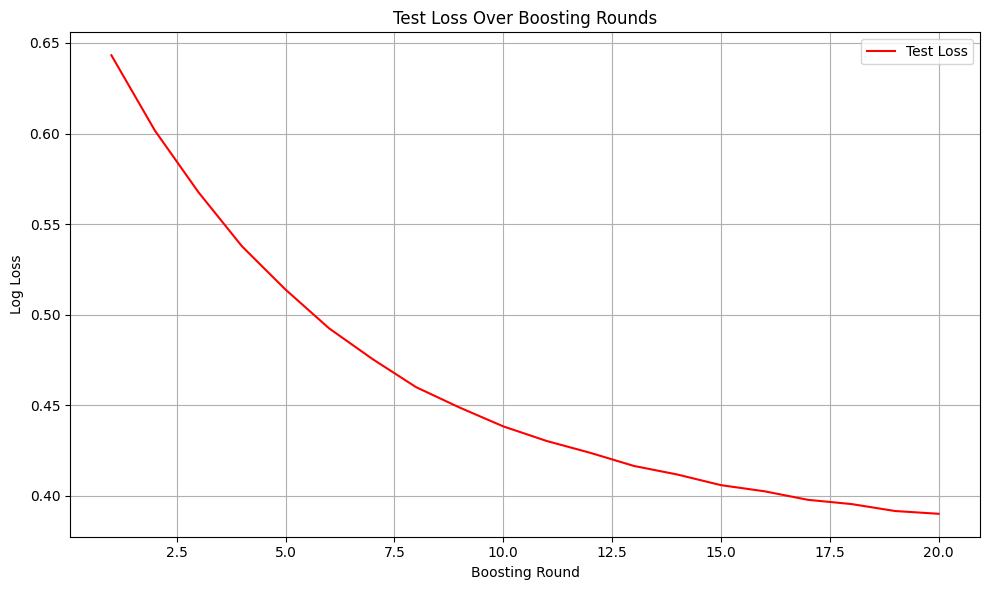

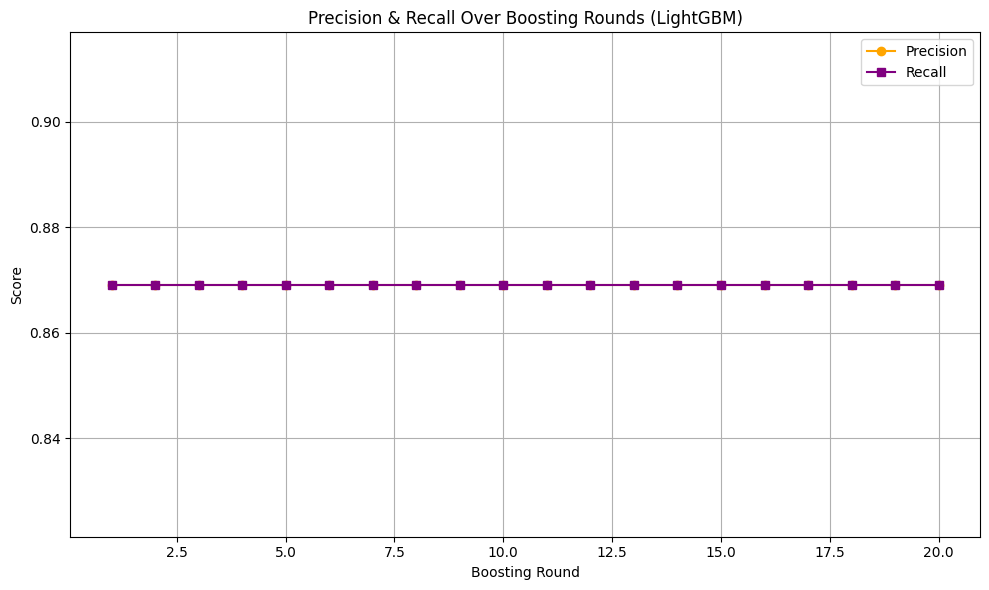

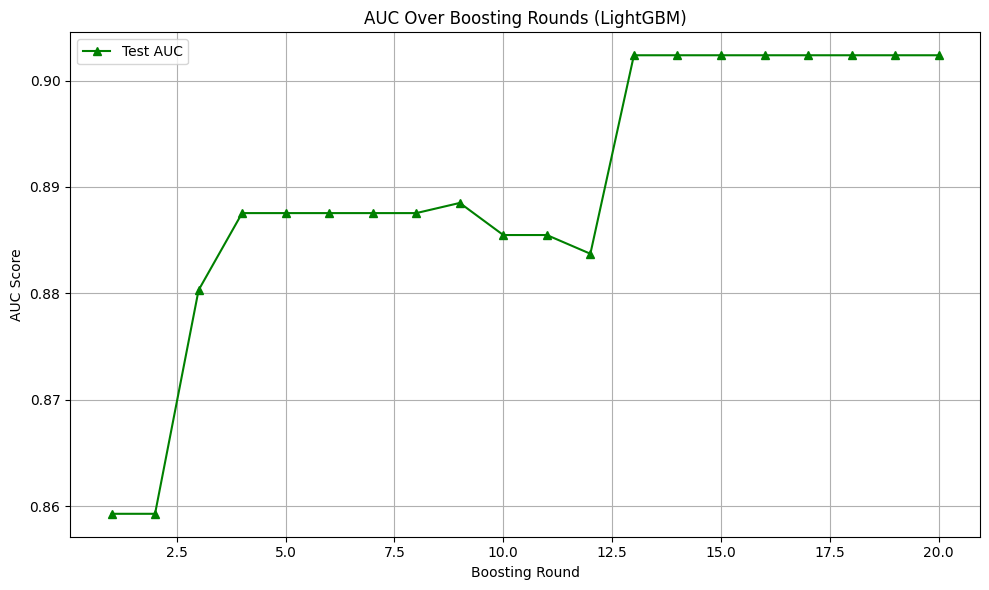

In [11]:
# Import libraries
import numpy as np
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create LightGBM Datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 2,
    'learning_rate': 0.1,
    'verbosity': -1  # <-- Correct way to suppress output
}

# Number of boosting rounds
num_boost_round = 20

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    num_boost_round=num_boost_round
)

# Metrics tracking
epoch_list = list(range(1, num_boost_round + 1))
precision_list = []
recall_list = []
test_auc_list = []
test_losses = []

for i in epoch_list:
    y_pred_proba = model.predict(X_test, num_iteration=i)
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred_proba)
    loss = -np.mean(y_test * np.log(y_pred_proba + 1e-15) + (1 - y_test) * np.log(1 - y_pred_proba + 1e-15))

    precision_list.append(precision)
    recall_list.append(recall)
    test_auc_list.append(auc)
    test_losses.append(loss)

    print(f"Epoch {i}: Precision = {precision:.4f}, Recall = {recall:.4f}, AUC = {auc:.4f}, Loss = {loss:.4f}")

# Plot Test Loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, test_losses, label="Test Loss", color='red')
plt.title("Test Loss Over Boosting Rounds")
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, precision_list, label="Precision", color='orange', marker='o')
plt.plot(epoch_list, recall_list, label="Recall", color='purple', marker='s')
plt.title("Precision & Recall Over Boosting Rounds (LightGBM)")
plt.xlabel("Boosting Round")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, test_auc_list, label="Test AUC", color='green', marker='^')
plt.title("AUC Over Boosting Rounds (LightGBM)")
plt.xlabel("Boosting Round")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
import numpy as np

# Assuming model.predict returns probabilities for a binary classification task
# and y_test is the true labels

# Final evaluation on the test set
y_final_proba = model.predict(X_test)
y_final_pred = (y_final_proba > 0.5).astype(int)

final_precision = precision_score(y_test, y_final_pred)
final_recall = recall_score(y_test, y_final_pred)
final_f1 = f1_score(y_test, y_final_pred)  # Calculate F1 score
final_auc = roc_auc_score(y_test, y_final_proba)
final_loss = -np.mean(y_test * np.log(y_final_proba + 1e-15) + (1 - y_test) * np.log(1 - y_final_proba + 1e-15))

print("\nFinal Evaluation on Test Set:")
print(f"Precision: {final_precision:.4f}")
print(f"Recall:    {final_recall:.4f}")
print(f"F1 Score:  {final_f1:.4f}")  # Print F1 score
print(f"AUC:       {final_auc:.4f}")
print(f"Log Loss:  {final_loss:.4f}")



Final Evaluation on Test Set:
Precision: 0.8692
Recall:    0.8692
F1 Score:  0.8692
AUC:       0.9024
Log Loss:  0.3902
